# Part 3: Bike Share Modelling

In this modelling section we’ll attempt to model bike hire counts using tree based methods (RF and GBM) as well as using a linear model (Elastic Net). Sklearn’s pipeline feature will be used to help with scaling and deriving feature interactions.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./Bike share data (Featurised).csv')
dfFeatures = df.iloc[:,:-6]
dfTargets = df.iloc[:,-6:]

For Elastic Net models and for making polynomial features we need the continuous data to be scaled. We'll set that up now.

In [3]:
def scaleCont(df):
    cols_to_scale = []
    cols_not_scale = []
    for col, item in dfFeatures.iteritems():
        if not (dfFeatures[col].sum() == 0 or (dfFeatures[col].min() == 0 and dfFeatures[col].max() == 1)):
            cols_to_scale.append(col)
        else:
            cols_not_scale.append(col)
   
    return cols_to_scale , cols_not_scale

cols_to_scale , cols_not_scale = scaleCont(dfFeatures)

dfFeatures = dfFeatures.reindex(columns = cols_to_scale+cols_not_scale)

In [4]:
#prepare post interactions column names
newCols = list(dfFeatures)
spent = []
for i in dfFeatures.columns:
    for j in dfFeatures.columns:
        if j in spent:
            continue
        elif i == j:
            continue
        else:
            col = i + 'X' + j
            
        newCols.append(col)
    spent.append(i)

### Random Forest Model

MAE: 37.82893705608621

Predicted Values vs True Values


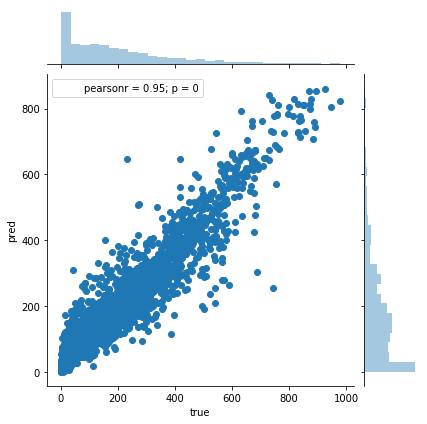

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

#Train, Test, Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, dfTargets['count'], test_size=0.25, random_state=42)

#custom scaler (must return a transform method)
from sklearn_pandas import DataFrameMapper
mapper = DataFrameMapper([(cols_to_scale, StandardScaler()), (cols_not_scale,None)])

#assemble pipe
from sklearn.pipeline import Pipeline
pipeRF = Pipeline([("scaler", mapper),("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                  ("RF",RandomForestRegressor(n_estimators=100, n_jobs = -1, random_state=0))])
#fit model
pipeRF.fit(X_train, y_train)

#model evaluation
y_pred = pipeRF.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('\nPredicted Values vs True Values')
sns.jointplot('true','pred', pd.DataFrame({'true':y_test,'pred':y_pred}))
ErrorRates = {'RF':metrics.mean_absolute_error(y_test, y_pred)}

Not bad. We'll later see if a linear model can do better.

What can we learn about our features from this model?

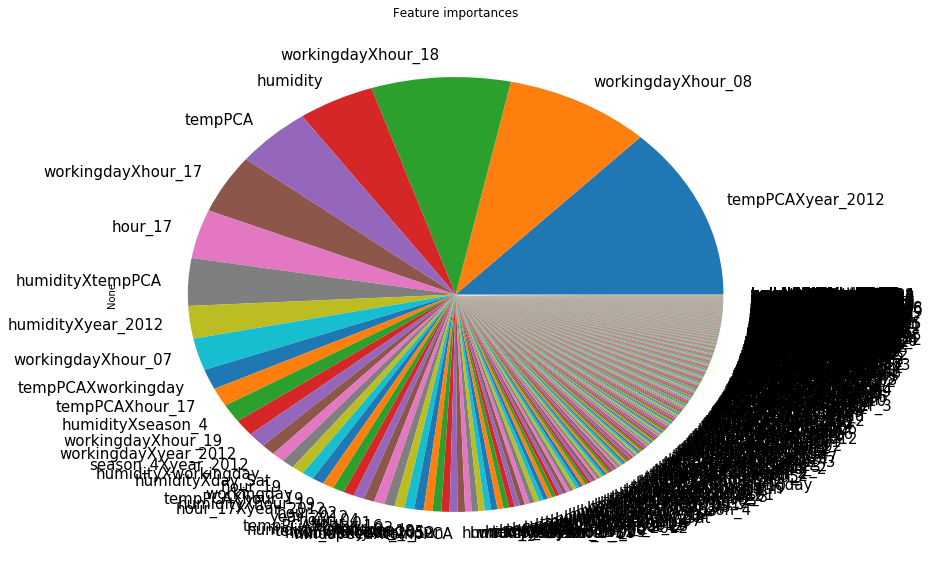

In [6]:
#feature insight
featImp = pd.Series(data = pipeRF.steps[2][1].feature_importances_, index = newCols).sort_values(ascending = False)
featImp.plot(fontsize = 15, title = 'Feature importances', figsize = (12,10), kind = 'pie')

Incredibly insightful! Many interactions are featured.

Temperature is by far the most prominent effect.

The feature with the largest importance is the temperature in 2012. This indicates that the bike share is more successful in its second year. Perhaps this analysis could be done once with the time trend removed so that we could better understand other factors.

Seasons and weather type seem to have little effect. Winter has some showing though.

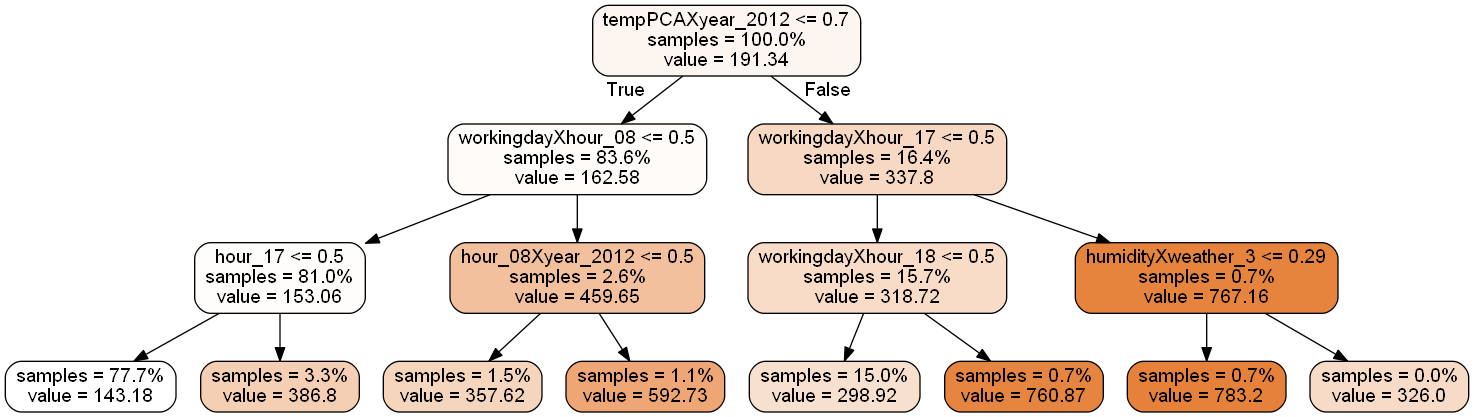

In [7]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

from sklearn.tree import DecisionTreeRegressor

rTree = DecisionTreeRegressor(max_depth=3)
rTree.fit(PolynomialFeatures(degree=2, include_bias=False, interaction_only=True ).fit_transform(mapper.fit_transform(X_train)),y_train)

dot_data = StringIO()  
export_graphviz(rTree, out_file=dot_data,feature_names=newCols ,filled=True, rounded = True, proportion = True, precision = 2, impurity = False)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

Temperature and year reign supreme. Our cyclists prefer it to be warm.

Otherwise the time of day is a massive determiner for hire counts.

### Elastic Net Model

MAE: 121.06164010414192

Predicted Values vs True Values


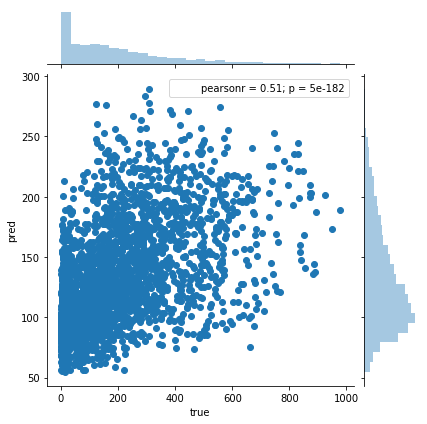

In [8]:
#Get lambda value for box cox transformation
coxLamdas = {}
coxLamdas['count'] = scipy.stats.boxcox(df['count']+1)[1]

#get transformed data to be y value
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, dfTargets['count cox'], test_size=0.25, random_state=42)

#Assemble pipe
from sklearn.linear_model import ElasticNet
pipeEnet = Pipeline([("scaler", mapper),("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                  ("eNet",ElasticNet())])
#fit model
pipeEnet.fit(X_train, y_train)

#evaluate model
y_pred = pipeEnet.predict(X_test)

#inverse cox transform
from scipy.special import inv_boxcox

y_pred_count_inv = inv_boxcox(y_pred, coxLamdas['count']) -1 
y_test_inv = inv_boxcox(y_test, coxLamdas['count']) -1 

print('MAE:', metrics.mean_absolute_error(y_test_inv, y_pred_count_inv))
print('\nPredicted Values vs True Values')
sns.jointplot('true','pred', pd.DataFrame({'true':y_test_inv,'pred':y_pred_count_inv}))
ErrorRates['eNet'] = metrics.mean_absolute_error(y_test_inv, y_pred_count_inv)

The Elastic Net Linear Model has not done nearly as well as the random forest. This is most likely due to the data being non-linear. The Box-cox transformation was insufficient. Despite the inferior predictions this model may still grant some insight into our feature set.


Number of features selected by eNet: 6


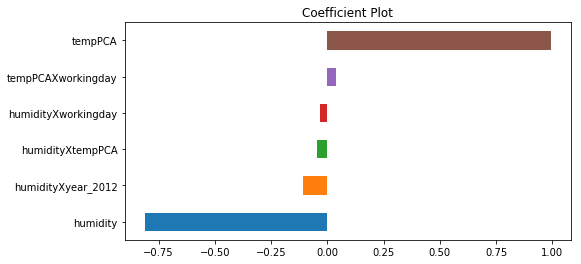

In [9]:
eNet_coef = pd.Series(data = pipeEnet.steps[2][1].coef_, index=newCols, name = 'value')
eNet_coef.sort_values(inplace=True)
eNet_coef = eNet_coef[eNet_coef !=0]
print('\nNumber of features selected by eNet: {}'.format(len(eNet_coef)))
eNet_coef.plot.barh(figsize = (8,4), title ='Coefficient Plot')

This is much less revealing than the forest. This is much less revealing than the forest. Its telling us that higher temperatures increase hire counts whilst higher humidity decreases hire counts.


I wonder if a more optimised Elastic Net could tell us more.

### Grid Search CV on Elastic Net

('eNet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))

Predicted Values vs True Values
MAE: 76.99065756165193


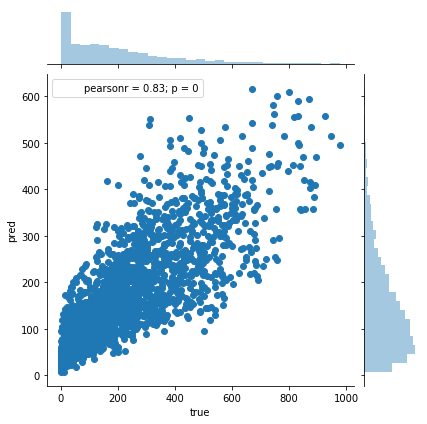

In [10]:
from sklearn.model_selection import GridSearchCV
#Grid params
param_grid = {
'eNet__l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
'eNet__alpha':list(np.linspace(0.1 , 1 , 10))}

#make grid and fit
eNetGrid = GridSearchCV(pipeEnet, param_grid = param_grid, cv=4, n_jobs=-1)

eNetGrid.fit(X_train, y_train)

#Best estimator
print(eNetGrid.best_estimator_.steps[2])

#evaluate model
y_pred = eNetGrid.predict(X_test)

#inverse cox transform
y_pred_count_inv = inv_boxcox(y_pred, coxLamdas['count']) -1 
y_test_inv = inv_boxcox(y_test, coxLamdas['count']) -1 

print('\nPredicted Values vs True Values')
print('MAE:', metrics.mean_absolute_error(y_test_inv, y_pred_count_inv))

sns.jointplot('true','pred', pd.DataFrame({'true':y_test_inv,'pred':y_pred_count_inv}))
ErrorRates['eNetGrid'] = metrics.mean_absolute_error(y_test_inv, y_pred_count_inv)

That’s a significant improvement on the non optimised eNet model. It still falls short of the RF model.

In [11]:
eNet_coef = pd.Series(data = eNetGrid.best_estimator_.steps[2][1].coef_, index=newCols, name = 'value')
eNet_coef.sort_values(inplace=True)
eNet_coef = eNet_coef[eNet_coef !=0]
print('\nNumber of features selected by eNet: {}'.format(len(eNet_coef)))


Number of features selected by eNet: 434


434 Features were preserved! Let's look at the 20 most influential

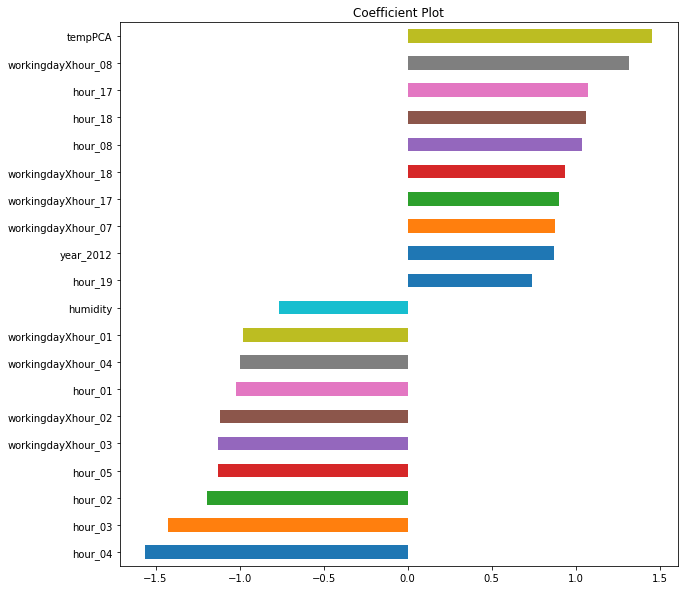

In [12]:
pd.concat((eNet_coef[:10],eNet_coef[-10:])).plot.barh(figsize = (10,10), title = 'Coefficient Plot')

This model is showing us more or less the same things as the RF model. Warm temps and 
commutting hours increase hires. High humidity and early morning times have a negative impact on hires.

#### Before moving onto the final question of "Is it better to model 'casual' and 'registered' separately?" I'd like to model the data using the famed Gradient Boosted Regressor that is winning so many tournaments.

#### It's another ensemble model like the random forest only this one builds models sequentially. Each new model tries to correct the error of the previous model.

### Gradient Boosting Regressor

MAE: 33.575676927604476

Predicted Values vs True Values


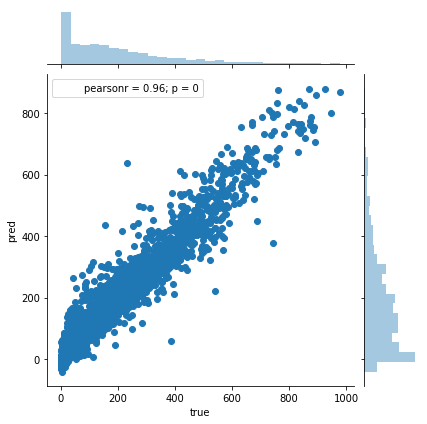

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, dfTargets['count'], test_size=0.25, random_state=42)
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=1000)

pipeGBM = Pipeline([("scaler", mapper),("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                  ("gbm", gbm)])
    
#fit model
pipeGBM.fit(X_train, y_train)

#model evaluation
y_pred_count = pipeGBM.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_count))
print('\nPredicted Values vs True Values')
sns.jointplot('true','pred', pd.DataFrame({'true':y_test,'pred':y_pred_count}))
ErrorRates['GBM'] = metrics.mean_absolute_error(y_test, y_pred_count)

The gradient boosting regressor has indeed performed better than the random forest.

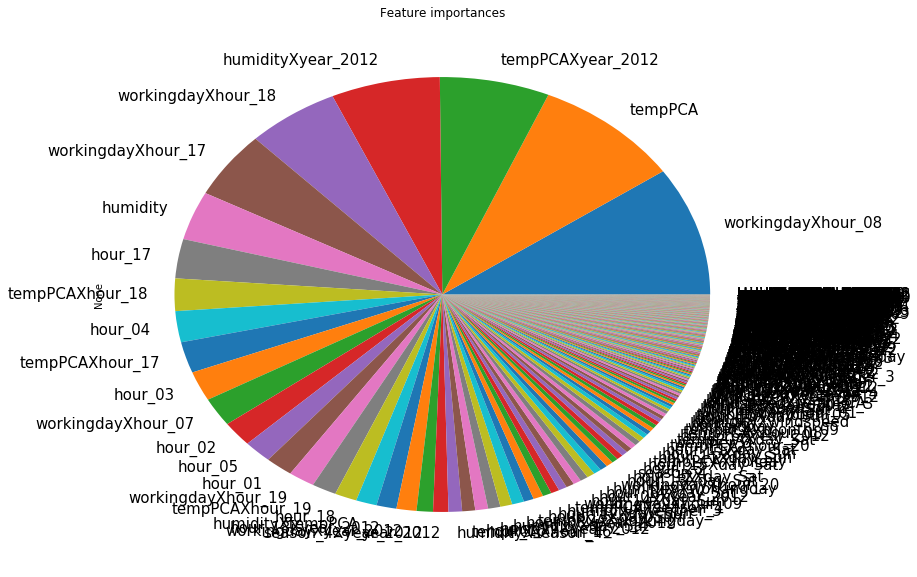

In [14]:
#feature insight
featImp = pd.Series(data = pipeGBM.steps[2][1].feature_importances_, index = newCols).sort_values(ascending = False)
featImp.plot(fontsize = 15, title = 'Feature importances', figsize = (12,10), kind = 'pie')

This model has made use of a more even distribution of the feature set.

We could optimise this further with a grid search but i think by now we fully understand what is driving bike hires

##### Onto the final question: Is it better to model 'casual' and 'registered' separately?

In [15]:
#GBM will be used once more
#registered
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, dfTargets['registered'], test_size=0.25, random_state=42)

pipeGBMr = Pipeline([("scaler", mapper),("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                  ("gbm", gbm)])
    
pipeGBMr.fit(X_train, y_train)

y_pred_registered = pipeGBMr.predict(X_test)

#casual
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, dfTargets['casual'], test_size=0.25, random_state=42)

pipeGBMc = Pipeline([("scaler", mapper),("interactions", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True )),\
                  ("gbm", gbm)])
    
pipeGBMc.fit(X_train, y_train)

y_pred_casual = pipeGBMc.predict(X_test)

#combined prediction
y_pred_combo = y_pred_casual + y_pred_registered
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, dfTargets['count'], test_size=0.25, random_state=42)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_combo))
ErrorRates['GBMcombo'] = metrics.mean_absolute_error(y_test, y_pred_combo)

MAE: 31.815630898221674


The error rate has decreased slightly! This suggests that casual and registered use of these bikes are influenced by different factors. 

Granted that combining predictions like this is a bit unorthodox. Predictions formed from adding the results from two models typically have much higher variance than those from a single model. Confidence intervals based on these predictions would be quite large.

Nonetheless this result should encourage us to investigate ‘registered’ and ‘casual’ in more detail. Understanding what drives those counts would be very helpful when trying to set up other bike share schemes.

In [16]:
print('Mean Absolute Error Rates')
pd.Series(ErrorRates).round()

Mean Absolute Error Rates


RF           38.0
eNet        121.0
eNetGrid     77.0
GBM          34.0
GBMcombo     32.0
dtype: float64

### Conclusions,  Recommendations & Improvements

We have seen that the demand for bikes is mostly determined by the time of day. Though that depends on which day it is. Most days are working days. On these days bikes are mostly being used around typical commuting times (7am to 9am and 5pm to 7pm). When its not a working day then time is less important unless its late night/early morning.

We must not forget environmental factors. People prefer cycling when it feels warmer. High temperatures encourage more bike hires. Though our cyclists don’t wish to become sweaty and so prefer it when there is low humidity.

This study was based on a bike share scheme in Washington DC. If the providers of this scheme wish to expand they should locate their next venture in a city that’s slightly warmer than DC and also has a high level of employment (since so many are using it to get to and from work). I would suggest Atlanta as it has similar levels of employment but a slightly fairer climate than DC.

There are many improvements that could be made to this investigation. Its likely that I tried to model the data on too many features. Feature banding may improve model performance. We did not need each of the 24 hours in a day, perhaps they could be grouped into 3-4 hour chunks. The models kept showing us hours right next to each other as important features after all.

Further tuning of the parameters for the GBM models could’ve been made. GridSearchCV might have provided others with models that reduced error even further.

The final models showed us that it may be better to model the constituents of ‘count’ separately. I suspect ‘registered’ users are more likely to use the bikes for general transport (like commuting) whilst ‘casual’ users are more likely to use the bikes for leisure. A more expansive investigation could cover those two dependent variables.